# HW4

Name: Xulai Wu <br>
Github Username: LukeWu5121 <br>
USC ID: 6591102106

In [60]:
#Import Statement
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegressionCV


## 1.b

In [61]:
data_path = "../data/AReM"
folders = ["bending1", "bending2", "cycling", "lying", "sitting", "standing", "walking"]

test_file = {"bending1":[1,2],   "bending2":[1,2],
             "cycling" :[1,2,3], "lying"   :[1,2,3], 
             "sitting" :[1,2,3], "standing":[1,2,3], 
             "walking" :[1,2,3]}
train_file = {folder: [] for folder in folders}
test_set = {folder: [] for folder in folders}

for folder in folders:
    folder_path = os.path.join(data_path, folder)
    all_files = sorted(os.listdir(folder_path))

    for idx, file in enumerate(all_files, start=1):
        if idx in test_file[folder]:
            test_set[folder].append(os.path.join(folder_path, file))
        else:
            train_file[folder].append(os.path.join(folder_path, file))

In [62]:
print("Train file:")
for folder, files in train_file.items():
    print(f"{folder}: {len(files)} files")
print("\nTest file:")
for folder, files in test_set.items():
    print(f"{folder}: {len(files)} files")

Train file:
bending1: 5 files
bending2: 4 files
cycling: 12 files
lying: 12 files
sitting: 12 files
standing: 12 files
walking: 12 files

Test file:
bending1: 2 files
bending2: 2 files
cycling: 3 files
lying: 3 files
sitting: 3 files
standing: 3 files
walking: 3 files


## 1.c.i
These are the time-domain features that are usually used in time series classification:
**min, max, mean, median, standard deviation, 1st quartile, 3rd quartile.**

## 1.c.ii

In [63]:
features_data = []
instance_id = 1

for folder in folders:
    folder_path = os.path.join(data_path, folder)  
    files = sorted(os.listdir(folder_path))  
    
    for file in files:
        file_path = os.path.join(folder_path, file)  
        #skip first 5 rows and 1 column
        df = pd.read_csv(file_path, skiprows=5, header=0)
        df = df.iloc[:, 1:]

        instance_features = [instance_id]  
        for col in df.columns:
            time_series = df[col]
            features = [
                    time_series.min(),
                    time_series.max(),
                    time_series.mean(),
                    time_series.median(),
                    time_series.std(),
                    time_series.quantile(0.25),  
                    time_series.quantile(0.75)   
                ]
            instance_features.extend(features)
        features_data.append(instance_features)
        instance_id += 1

columns = ["Instance"]
for i in range(6):  
    columns.extend([
        f"min{i+1}", f"max{i+1}", f"mean{i+1}",
        f"median{i+1}", f"std{i+1}", f"1st quart{i+1}", f"3rd quart{i+1}"
    ])
features_table = pd.DataFrame(features_data, columns=columns)

features_table 


,Instance,min1,max1,mean1,median1,std1,1st quart1,3rd quart1,min2,max2,...,std5,1st quart5,3rd quart5,min6,max6,mean6,median6,std6,1st quart6,3rd quart6
0,1,37.25,45.00,40.627662,40.50,1.477170,39.25,42.00,0.0,1.30,...,2.190586,33.000,36.00,0.0,1.92,0.569061,0.43,0.582568,0.00,1.300
1,2,38.00,45.67,42.811023,42.50,1.436515,42.00,43.67,0.0,1.22,...,1.992534,32.000,34.50,0.0,3.11,0.572276,0.43,0.601070,0.00,1.300
2,3,35.00,47.40,43.958580,44.33,1.557897,43.00,45.00,0.0,1.70,...,1.985273,35.450,36.50,0.0,1.79,0.494322,0.43,0.513547,0.00,0.940
3,4,33.00,47.75,42.169061,43.50,3.666929,39.10,45.00,0.0,3.00,...,3.853317,30.415,36.33,0.0,2.18,0.612088,0.50,0.523923,0.00,1.000
4,5,33.00,45.75,41.672526,41.75,2.242551,41.33,42.75,0.0,2.83,...,2.413538,28.415,31.25,0.0,1.79,0.384092,0.43,0.389176,0.00,0.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,84,20.75,46.25,34.761273,35.25,4.746951,31.67,38.25,0.0,12.68,...,3.176255,14.250,18.33,0.0,9.39,3.295136,3.27,1.642364,2.05,4.310
84,85,21.50,51.00,34.927328,35.50,4.647077,32.00,38.00,0.0,12.21,...,3.194477,14.225,18.25,0.0,10.21,3.284259,3.03,1.700157,2.12,4.500
85,86,18.33,47.67,34.337390,34.75,4.953025,31.25,38.00,0.0,12.48,...,3.001243,13.750,18.00,0.0,8.01,3.260000,2.96,1.618608,2.05,4.320
86,87,18.33,45.75,34.621482,35.25,4.712972,31.50,38.00,0.0,15.37,...,2.904447,14.000,18.25,0.0,8.86,3.287015,3.00,1.681013,2.12,4.250


## 1.c.iii

In [64]:
bootstrap_samples = 2000
bootstrap_results = {}

for col in features_table.columns[1:]:
    bootstrap_std = []

    for _ in range(bootstrap_samples):
        sample = features_table[col].sample(frac=1, replace=True)
        bootstrap_std.append(sample.std())
    
    lower_bound = np.percentile(bootstrap_std, 5)
    upper_bound = np.percentile(bootstrap_std, 95)

    bootstrap_results[col] = (lower_bound, upper_bound)

bootstrap_df = pd.DataFrame(bootstrap_results, index=["5th Percentile", "95th Percentile"]).T
bootstrap_df

,5th Percentile,95th Percentile
min1,8.242640,10.783818
max1,3.330740,5.308755
mean1,4.723226,5.909596
median1,4.784667,5.999248
std1,1.579530,1.947277
1st quart1,5.565904,6.636458
3rd quart1,4.349176,5.858806
min2,0.000000,0.000000
max2,4.626265,5.394618
mean2,1.400764,1.706941


## 1.c.iv

Mean, Min, Max
Since the dataset are information about a person, there won't be a lot of outliers, so we can choose these three factors to find out where the whole dataset goes.

## QUESTION 2

In [65]:
#Create a new table for training data
features_train_data = []  
instance_id = 1  
train_set_files = []

for folder, files in train_file.items():
    train_set_files.extend(files)  

for file_path in train_set_files:
        df = pd.read_csv(file_path, skiprows=5, header=0)
        df = df.iloc[:, 1:]  
        instance_features = [instance_id]  
        
        for col in df.columns:
            time_series = df[col]
            features = [
                time_series.min(),
                time_series.max(),
                time_series.mean(),
                time_series.median(),
                time_series.std(),
                time_series.quantile(0.25),
                time_series.quantile(0.75),
            ]
            instance_features.extend(features)
        features_train_data.append(instance_features)  
        instance_id += 1  

columns = ["Instance"]
for i in range(6):  
    columns.extend([
        f"min{i+1}", f"max{i+1}", f"mean{i+1}", f"median{i+1}",
        f"std{i+1}", f"1st quart{i+1}", f"3rd quart{i+1}"
    ])

features_table_train = pd.DataFrame(features_train_data, columns=columns)
features_table_train


,Instance,min1,max1,mean1,median1,std1,1st quart1,3rd quart1,min2,max2,...,std5,1st quart5,3rd quart5,min6,max6,mean6,median6,std6,1st quart6,3rd quart6
0,1,35.00,47.40,43.958580,44.33,1.557897,43.00,45.00,0.0,1.70,...,1.985273,35.450,36.50,0.0,1.79,0.494322,0.43,0.513547,0.00,0.940
1,2,33.00,47.75,42.169061,43.50,3.666929,39.10,45.00,0.0,3.00,...,3.853317,30.415,36.33,0.0,2.18,0.612088,0.50,0.523923,0.00,1.000
2,3,33.00,45.75,41.672526,41.75,2.242551,41.33,42.75,0.0,2.83,...,2.413538,28.415,31.25,0.0,1.79,0.384092,0.43,0.389176,0.00,0.500
3,4,37.00,48.00,43.459562,43.25,1.383869,42.50,45.00,0.0,1.58,...,2.454845,22.250,24.00,0.0,5.26,0.679102,0.50,0.623071,0.43,0.870
4,5,36.25,48.00,43.973236,44.50,1.617545,43.33,44.67,0.0,1.50,...,3.289399,20.500,23.75,0.0,2.96,0.556472,0.49,0.487674,0.00,0.830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,65,20.75,46.25,34.761273,35.25,4.746951,31.67,38.25,0.0,12.68,...,3.176255,14.250,18.33,0.0,9.39,3.295136,3.27,1.642364,2.05,4.310
65,66,21.50,51.00,34.927328,35.50,4.647077,32.00,38.00,0.0,12.21,...,3.194477,14.225,18.25,0.0,10.21,3.284259,3.03,1.700157,2.12,4.500
66,67,18.33,47.67,34.337390,34.75,4.953025,31.25,38.00,0.0,12.48,...,3.001243,13.750,18.00,0.0,8.01,3.260000,2.96,1.618608,2.05,4.320
67,68,18.33,45.75,34.621482,35.25,4.712972,31.50,38.00,0.0,15.37,...,2.904447,14.000,18.25,0.0,8.86,3.287015,3.00,1.681013,2.12,4.250


## 2.a.i

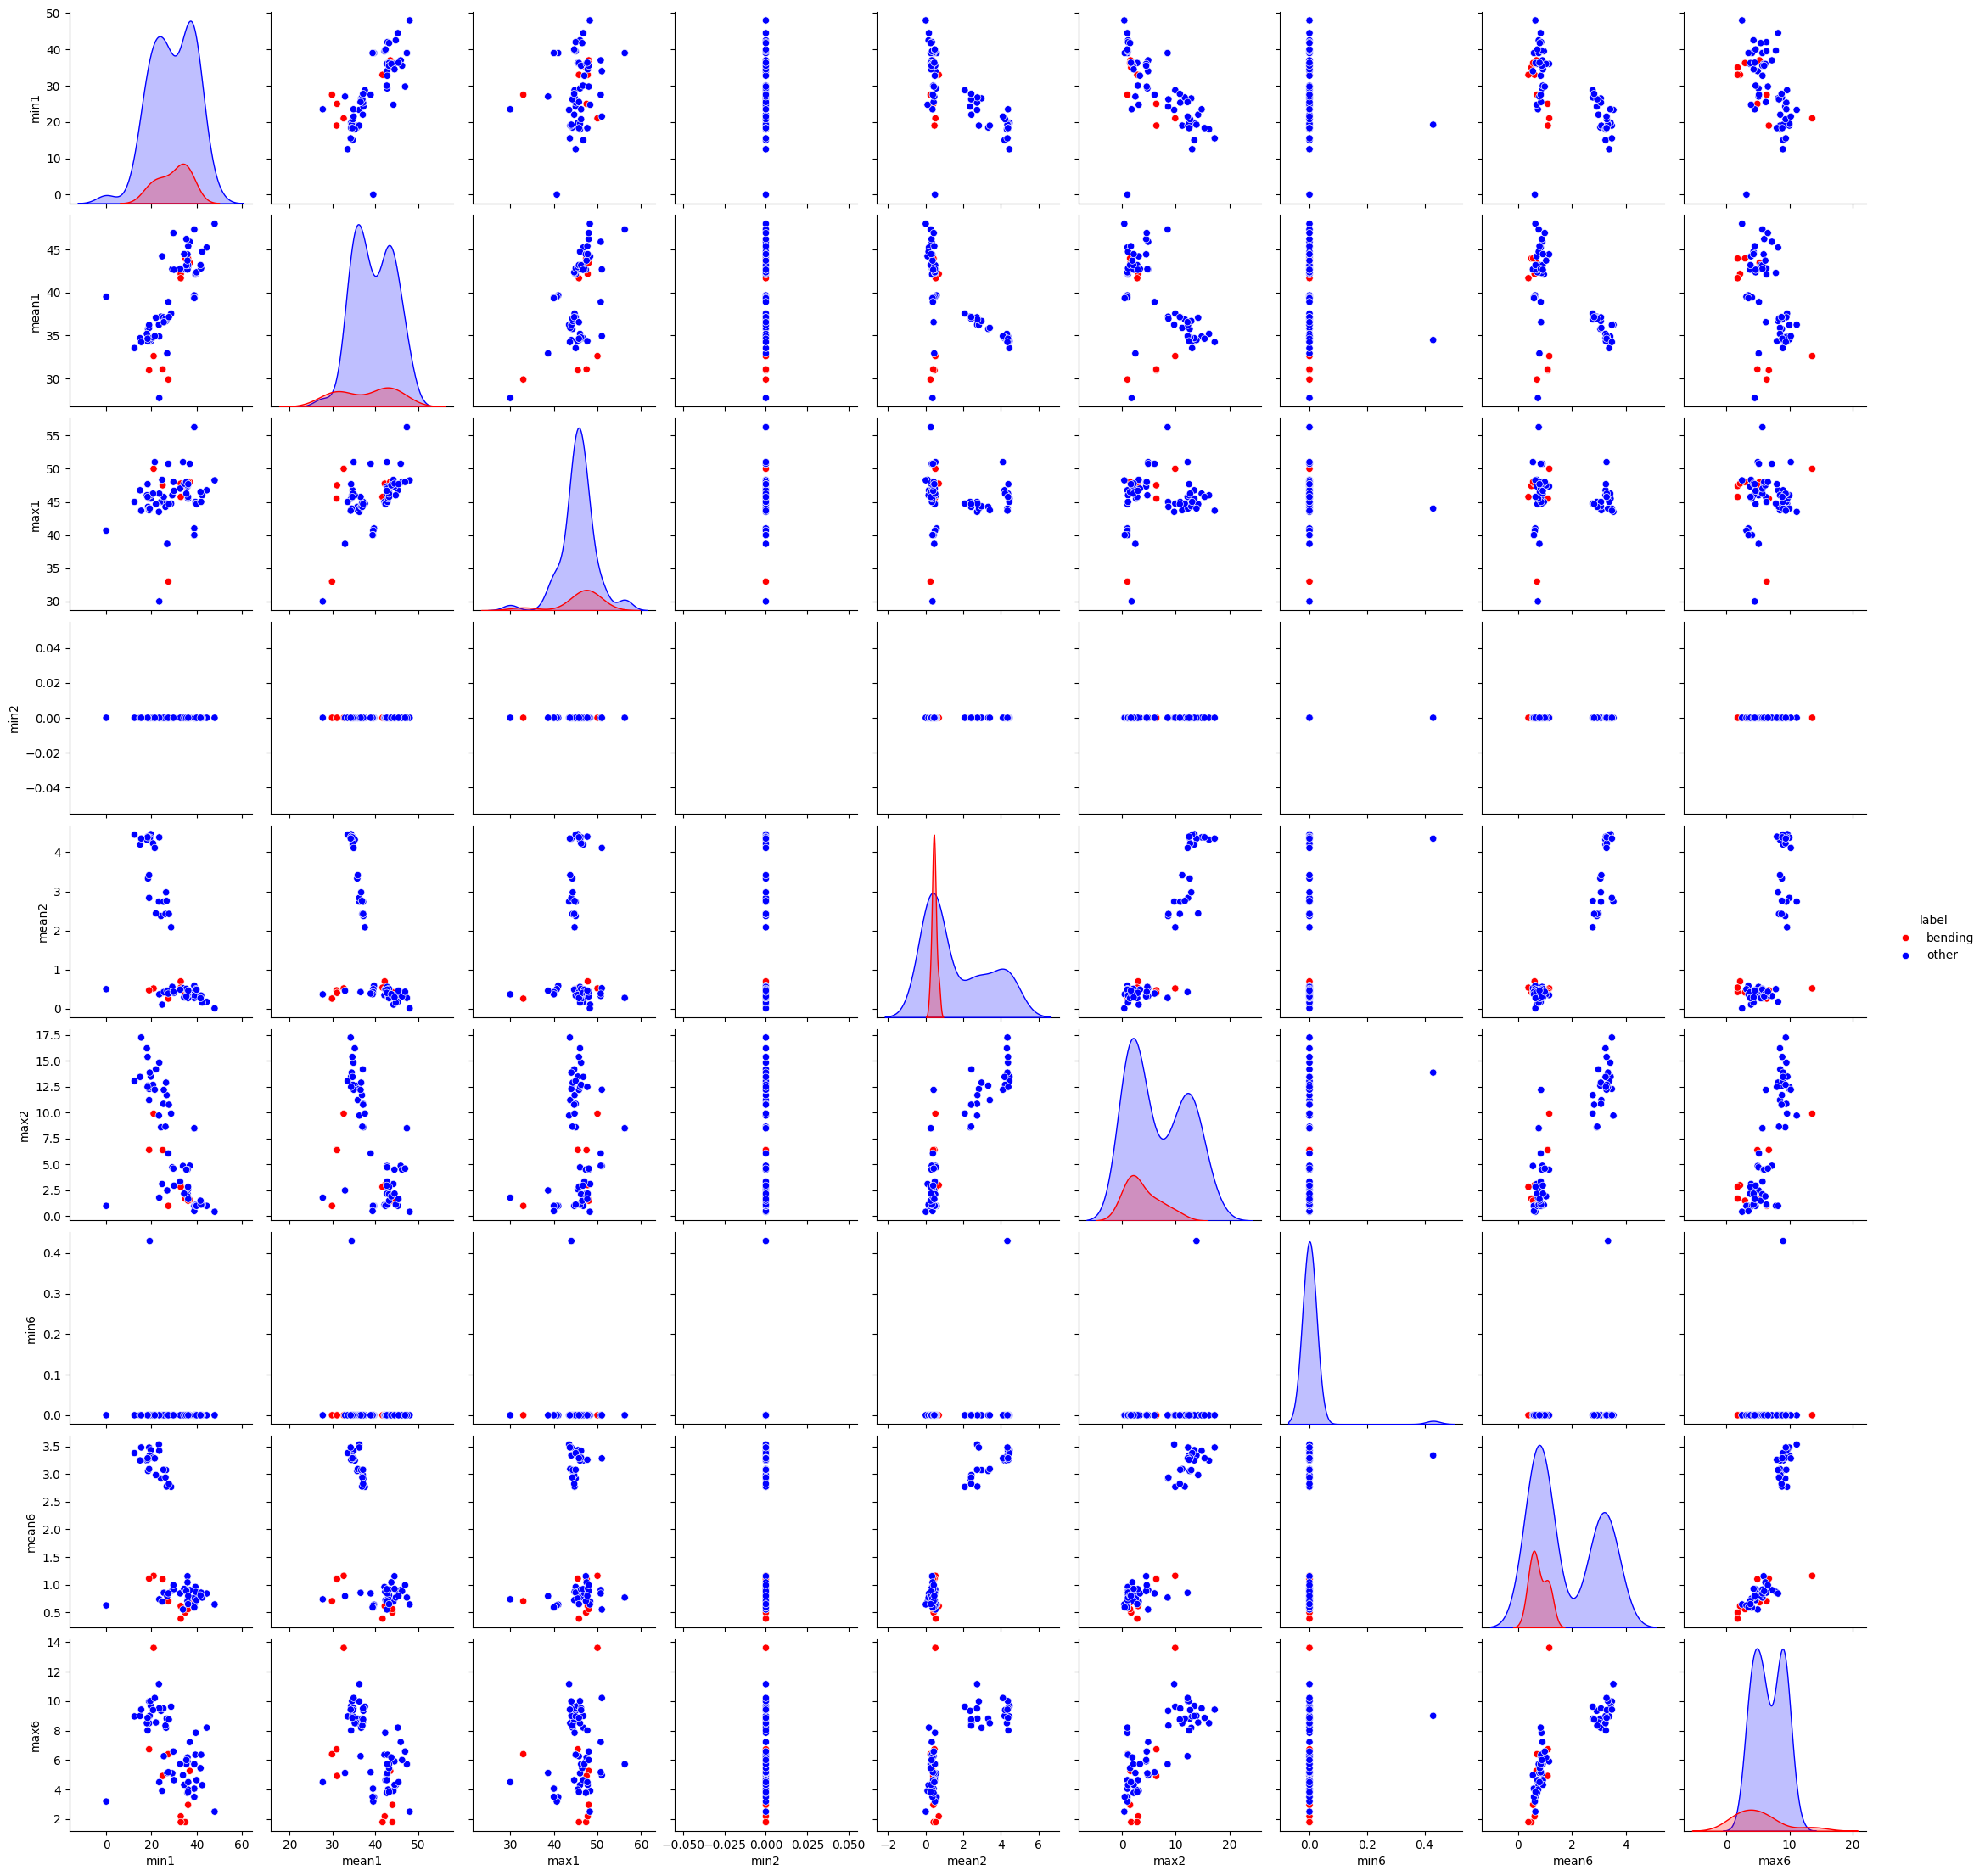

In [66]:
selected_features = [
    "min1", "mean1", "max1", "min2", "mean2", "max2", "min6", "mean6", "max6"
]
features_table_train["label"] = features_table_train["Instance"].apply(lambda x: "bending" if x <= 9 else "other")
sns.pairplot(features_table_train[selected_features + ["label"]], hue="label", palette={"bending": "red", "other": "blue"})
plt.show()


## 2.a.ii

In [67]:
features_part1_data = []
features_part2_data = []  
instance_ids = []  
instance_id = 1  

train_set_files = []  
for folder, files in train_file.items():
    train_set_files.extend(files)

for file_path in train_set_files:
    df = pd.read_csv(file_path, skiprows=5, header=0)
    df = df.iloc[:, 1:]  

   
    df_part1 = df.iloc[:240, :]  
    df_part2 = df.iloc[240:, :]  

    instance_features_part1 = []
    for col in df_part1.columns:
        time_series = df_part1[col]
        features = [
            time_series.min(),
            time_series.max(),
            time_series.mean(),
            time_series.median(),
            time_series.std(),
            time_series.quantile(0.25),
            time_series.quantile(0.75),
        ]
        instance_features_part1.extend(features)

    instance_features_part2 = []
    for col in df_part2.columns:
        time_series = df_part2[col]
        features = [
            time_series.min(),
            time_series.max(),
            time_series.mean(),
            time_series.median(),
            time_series.std(),
            time_series.quantile(0.25),
            time_series.quantile(0.75),
        ]
        instance_features_part2.extend(features)

    
    features_part1_data.append(instance_features_part1)
    features_part2_data.append(instance_features_part2)
    instance_ids.append(instance_id)
    instance_id += 1  

columns_part1 = []
columns_part2 = []
for i in range(6):  
    columns_part1.extend([
        f"min{i+1}_part1", f"max{i+1}_part1", f"mean{i+1}_part1", f"median{i+1}_part1",
        f"std{i+1}_part1", f"1st_quart{i+1}_part1", f"3rd_quart{i+1}_part1"
    ])
    columns_part2.extend([
        f"min{i+1}_part2", f"max{i+1}_part2", f"mean{i+1}_part2", f"median{i+1}_part2",
        f"std{i+1}_part2", f"1st_quart{i+1}_part2", f"3rd_quart{i+1}_part2"
    ])

df_part1 = pd.DataFrame(features_part1_data, columns=columns_part1)
df_part2 = pd.DataFrame(features_part2_data, columns=columns_part2)
features_table_split = pd.concat([pd.DataFrame({"Instance": instance_ids}), df_part1, df_part2], axis=1)
features_table_split.shape
features_table_split


,Instance,min1_part1,max1_part1,mean1_part1,median1_part1,std1_part1,1st_quart1_part1,3rd_quart1_part1,min2_part1,max2_part1,...,std5_part2,1st_quart5_part2,3rd_quart5_part2,min6_part2,max6_part2,mean6_part2,median6_part2,std6_part2,1st_quart6_part2,3rd_quart6_part2
0,1,36.50,46.50,44.062708,44.500,1.551978,43.2500,45.0000,0.0,1.50,...,2.302950,33.000,36.250,0.00,1.50,0.387992,0.00,0.479503,0.000,0.710
1,2,33.75,47.75,43.247292,45.000,3.470825,42.0000,45.2500,0.0,3.00,...,3.758886,28.750,33.375,0.00,2.18,0.583431,0.47,0.491182,0.000,0.870
2,3,33.00,45.75,41.612875,42.330,3.114045,39.6525,44.0625,0.0,2.83,...,2.062748,28.290,30.375,0.00,1.50,0.346987,0.43,0.363819,0.000,0.500
3,4,39.00,48.00,44.129542,45.000,1.347100,43.5000,45.0000,0.0,1.09,...,1.884860,22.500,23.750,0.00,4.06,0.543180,0.50,0.474316,0.430,0.710
4,5,36.67,46.25,43.503917,43.750,1.290684,42.4575,44.5000,0.0,1.30,...,1.925969,21.000,23.500,0.00,2.96,0.580167,0.50,0.481199,0.415,0.830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,65,22.33,46.00,34.990917,35.500,4.752501,32.0000,38.7500,0.0,12.68,...,3.330429,14.000,18.500,0.00,9.39,3.420628,3.35,1.644726,2.170,4.415
65,66,21.50,45.67,34.744333,35.500,4.285498,32.0000,37.7500,0.0,12.21,...,3.149443,14.500,18.250,0.00,10.21,3.221799,3.08,1.667596,2.050,4.380
66,67,18.33,45.00,33.906250,34.500,5.146590,30.4575,37.5000,0.0,12.44,...,3.381622,13.670,18.250,0.00,8.01,3.279414,2.96,1.672532,2.050,4.455
67,68,18.33,44.00,34.897917,35.875,4.827822,32.0000,38.7500,0.0,12.36,...,2.886854,13.875,18.250,0.47,8.84,3.416192,3.11,1.707474,2.170,4.370


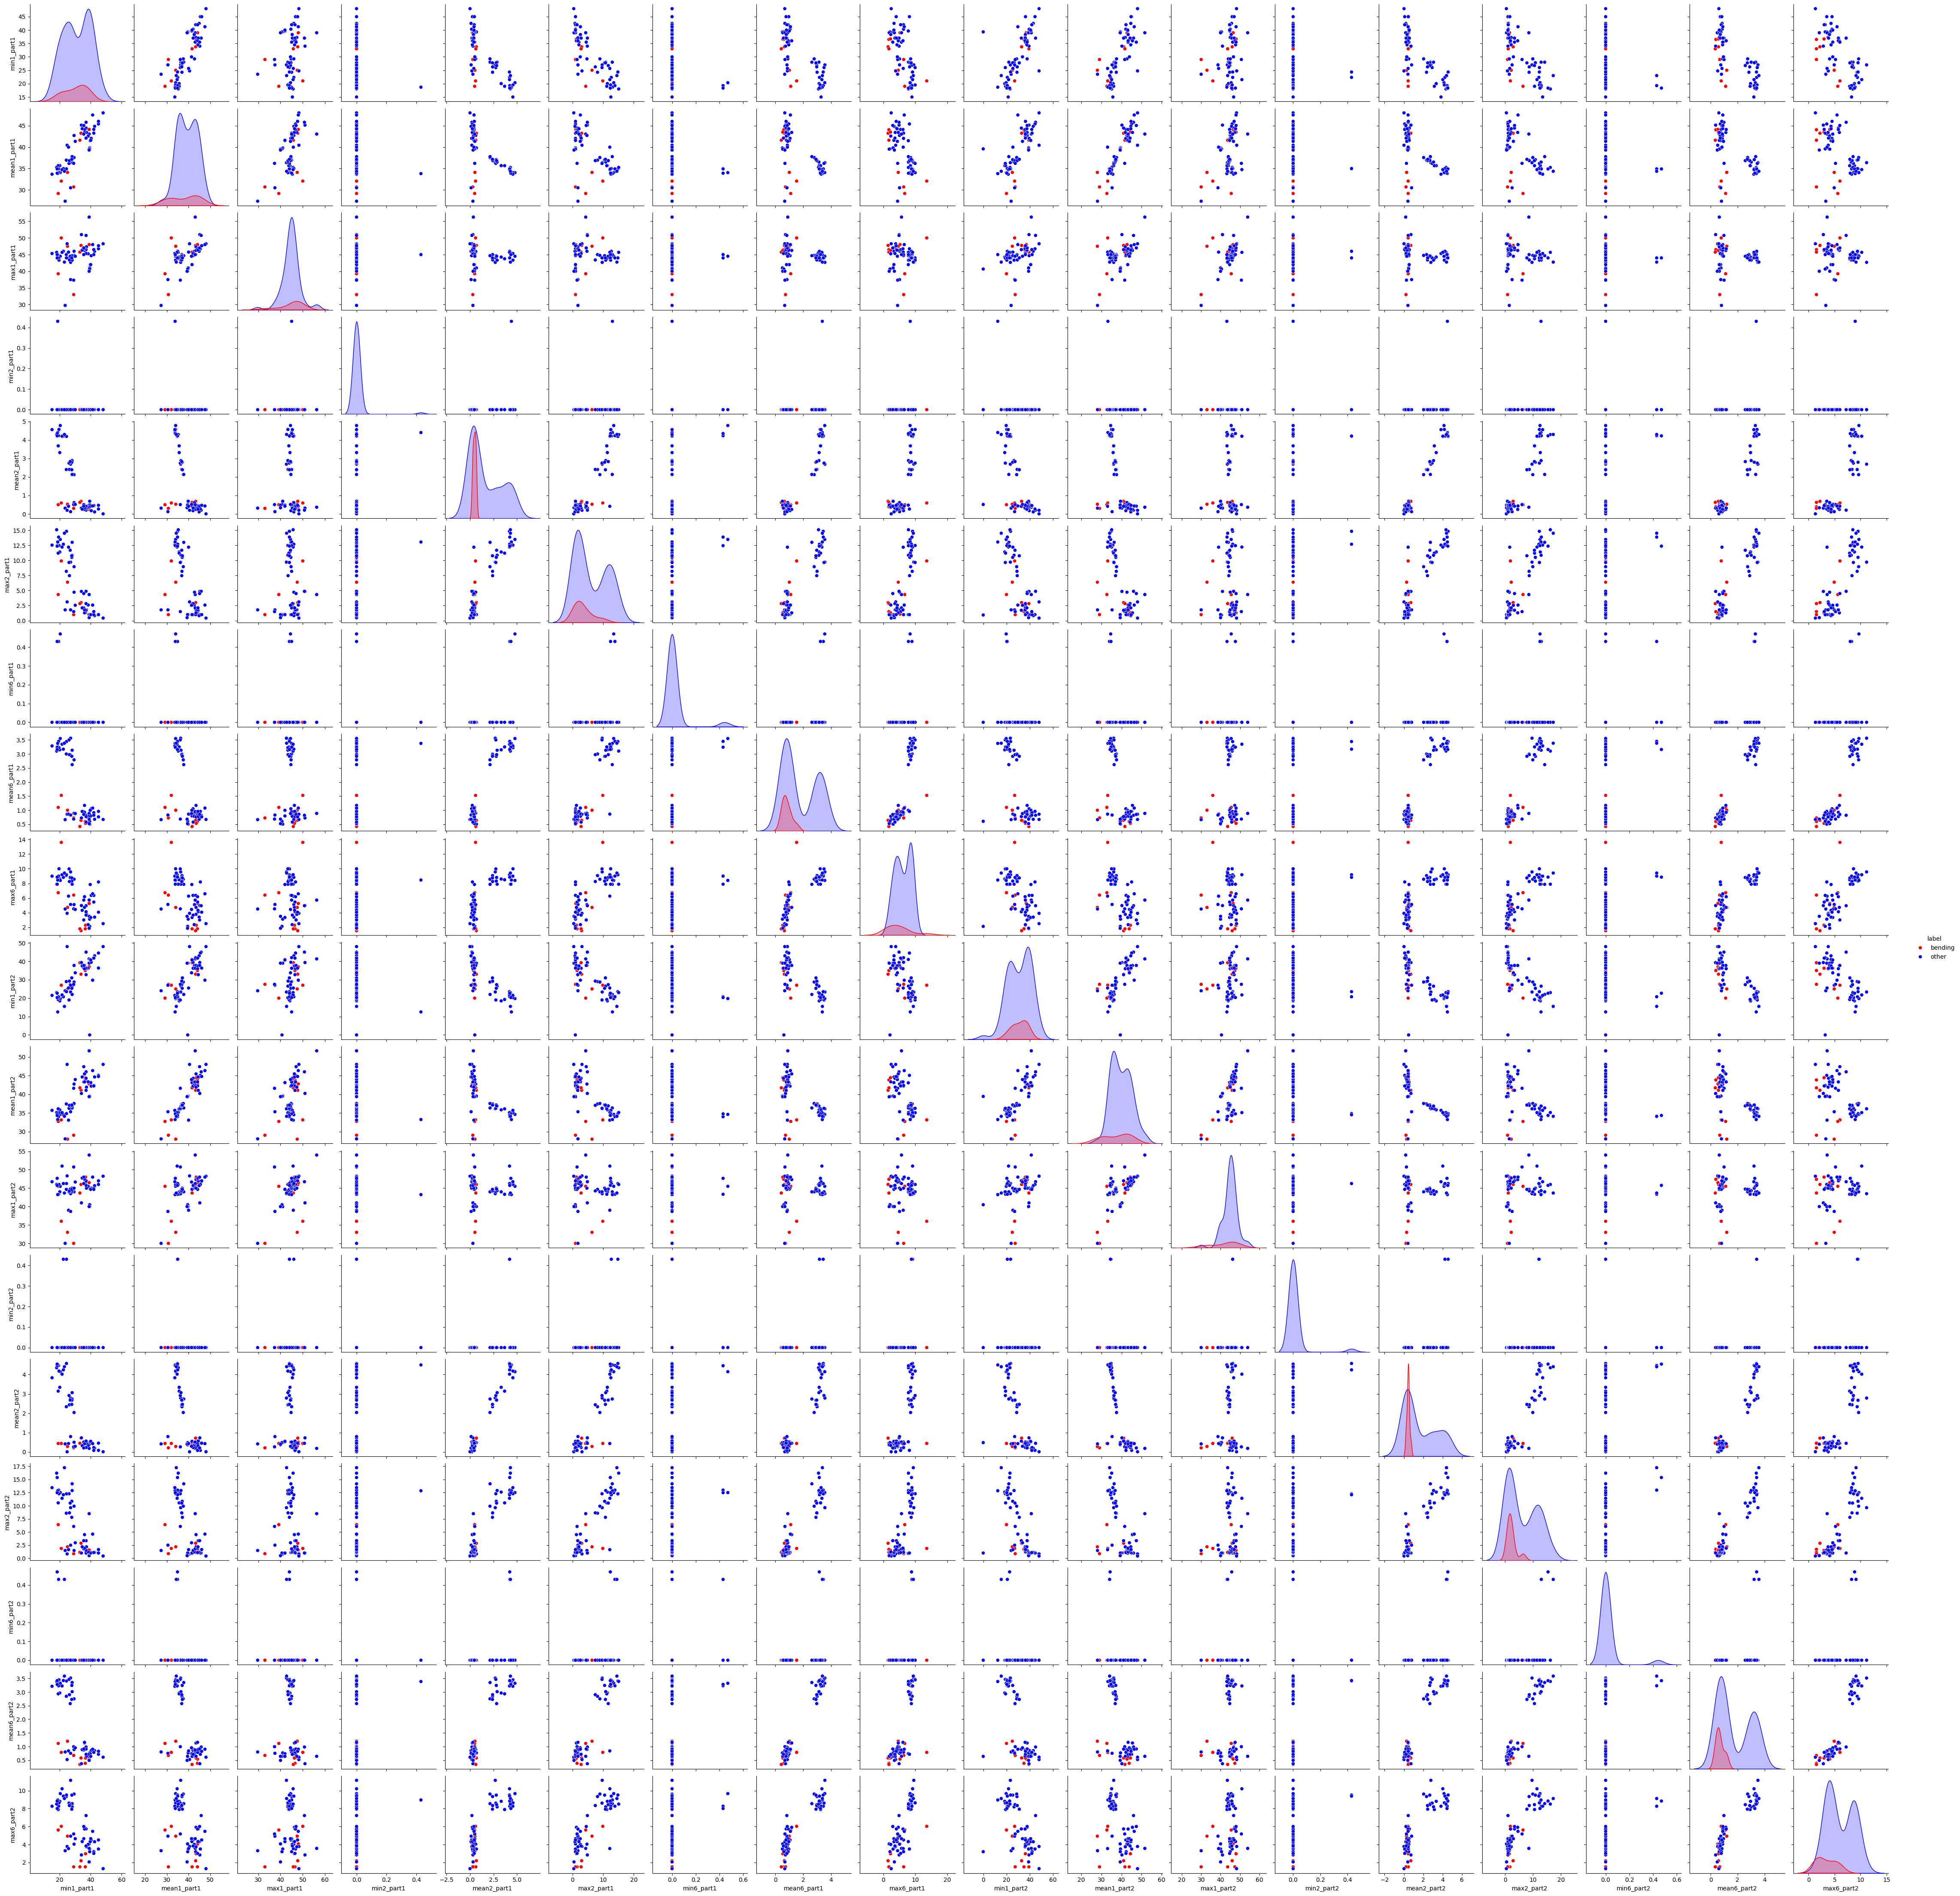

In [68]:
selected_features_split = [
    "min1_part1", "mean1_part1", "max1_part1", "min2_part1", "mean2_part1", "max2_part1",
    "min6_part1", "mean6_part1", "max6_part1",
    "min1_part2", "mean1_part2", "max1_part2", "min2_part2", "mean2_part2", "max2_part2",
    "min6_part2", "mean6_part2", "max6_part2"
]
features_table_split["label"] = features_table_split["Instance"].apply(lambda x: "bending" if x<= 9 else "other")
sns.pairplot(features_table_split[selected_features_split + ["label"]], hue="label", palette={"bending": "red", "other": "blue"})
plt.show()


There is no significant difference between them

## 2.a.iii

In [69]:
l_values = range(1, 21)  
features_dict = {}

for l in l_values:
    features_train_data = []
    instance_id = 1

    for file_path in train_set_files:
        df = pd.read_csv(file_path, skiprows=5, header=0)
        df = df.iloc[:, 1:]  
        segment_size = df.shape[0] // l
        instance_features = [instance_id]  

        for i in range(l):
            df_part = df.iloc[i * segment_size: (i + 1) * segment_size, :]
            for col in df_part.columns:
                time_series = df_part[col]
                features = [
                    time_series.min(),
                    time_series.max(),
                    time_series.mean(),
                    time_series.median(),
                    time_series.std(),
                    time_series.quantile(0.25),
                    time_series.quantile(0.75),
                ]
                instance_features.extend(features)

        features_train_data.append(instance_features)
        instance_id += 1

    columns = ["Instance"]
    for i in range(6): 
        for j in range(l):
            columns.extend([
                f"min{i+1}_seg{j+1}", f"max{i+1}_seg{j+1}", f"mean{i+1}_seg{j+1}", f"median{i+1}_seg{j+1}",
                f"std{i+1}_seg{j+1}", f"1st_quart{i+1}_seg{j+1}", f"3rd_quart{i+1}_seg{j+1}"
            ])

    features_dict[l] = pd.DataFrame(features_train_data, columns=columns)


In [70]:
for l in features_dict:
    features_dict[l]["label"] = features_dict[l]["Instance"].apply(lambda x: 1 if x <= 9 else 0)

In [71]:
def optimize_l_and_p(features_dict, labels, l_values=range(1, 21), cv_folds=5):
    best_results = []  

    for l in l_values:
        print(f"Processing l = {l} ...")
        X = features_dict[l].drop(columns=["Instance"])
        selected_cols = [col for col in X.columns if any(stat in col for stat in ["max", "min", "mean"])]
        X = X[selected_cols]  
        y = labels

        model = LogisticRegression(max_iter=1000)
        selector = RFECV(model, step=1, cv=cv_folds, scoring='accuracy', n_jobs=-1)
        selector.fit(X, y)
        best_p = selector.n_features_
        best_score = max(selector.cv_results_['mean_test_score'])

       
        best_results.append((l, best_p, best_score))
        print(f"Segments: {l}, Selected Features: {best_p}, Best Score: {best_score:.4f}")

    results_df = pd.DataFrame(best_results, columns=['l', 'p', 'accuracy'])
    return results_df

In [72]:
labels = features_dict[1]["Instance"].apply(lambda x: 1 if x <= 9 else 0)
results_df = optimize_l_and_p(features_dict, labels)
results_df

Processing l = 1 ...
Segments: 1, Selected Features: 5, Best Score: 0.9857
Processing l = 2 ...
Segments: 2, Selected Features: 1, Best Score: 0.9571
Processing l = 3 ...
Segments: 3, Selected Features: 6, Best Score: 0.9714
Processing l = 4 ...
Segments: 4, Selected Features: 1, Best Score: 0.9560
Processing l = 5 ...
Segments: 5, Selected Features: 1, Best Score: 0.9571
Processing l = 6 ...
Segments: 6, Selected Features: 28, Best Score: 0.9714
Processing l = 7 ...
Segments: 7, Selected Features: 24, Best Score: 0.9857
Processing l = 8 ...
Segments: 8, Selected Features: 20, Best Score: 0.9560
Processing l = 9 ...
Segments: 9, Selected Features: 40, Best Score: 0.9714
Processing l = 10 ...
Segments: 10, Selected Features: 48, Best Score: 0.9714
Processing l = 11 ...
Segments: 11, Selected Features: 12, Best Score: 0.9714
Processing l = 12 ...
Segments: 12, Selected Features: 22, Best Score: 0.9714
Processing l = 13 ...
Segments: 13, Selected Features: 19, Best Score: 0.9857
Processin

,l,p,accuracy
0,1,5,0.985714
1,2,1,0.957143
2,3,6,0.971429
3,4,1,0.956044
4,5,1,0.957143
5,6,28,0.971429
6,7,24,0.985714
7,8,20,0.956044
8,9,40,0.971429
9,10,48,0.971429


## 2.a.iv

Optimization terminated successfully.
         Current function value: 0.261829
         Iterations 9
Logistic Regression Coefficients (β_i):
const             -1.929718
min1_seg1          1.066028
max1_seg1         -0.255768
mean1_seg1        -1.837444
median1_seg1       1.906423
std1_seg1          2.399107
1st_quart1_seg1   -0.873667
dtype: float64

P-values:
const              0.699179
min1_seg1          0.008918
max1_seg1          0.332974
mean1_seg1         0.102350
median1_seg1       0.013356
std1_seg1          0.087228
1st_quart1_seg1    0.401448
dtype: float64


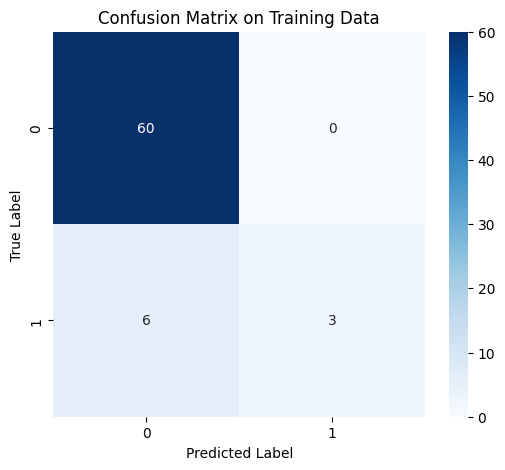

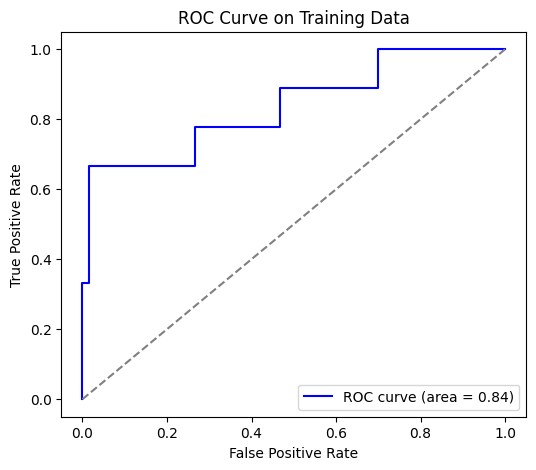

In [73]:
l_best = 3
p_best = 6
features_table = features_dict[l_best]  

features_table["label"] = features_table["Instance"].apply(lambda x: 1 if x <= 9 else 0)
X_train = features_table.drop(columns=["Instance", "label"])  
X_train = X_train.iloc[:, :p_best]  

y_train = features_table["label"].values
model = sm.Logit(y_train, sm.add_constant(X_train))
result = model.fit()

print("Logistic Regression Coefficients (β_i):")
print(result.params)
print("\nP-values:")
print(result.pvalues)

y_train_pred = (result.predict(sm.add_constant(X_train)) > 0.5).astype(int)
conf_matrix = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Training Data")
plt.show()

fpr, tpr, _ = roc_curve(y_train, result.predict(sm.add_constant(X_train)))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Training Data')
plt.legend(loc='lower right')
plt.show()


## 2.a.v

In [74]:
#Create a new table for test data
features_test_data = []  
instance_id = 1  
test_set_files = []

for folder, files in test_set.items():
    test_set_files.extend(files)  

for file_path in test_set_files:
        df = pd.read_csv(file_path, skiprows=5, header=0)
        df = df.iloc[:, 1:]  
        instance_features = [instance_id]  
        
        for col in df.columns:
            time_series = df[col]
            features = [
                time_series.min(),
                time_series.max(),
                time_series.mean(),
                time_series.median(),
                time_series.std(),
                time_series.quantile(0.25),
                time_series.quantile(0.75),
            ]
            instance_features.extend(features)
        features_test_data.append(instance_features)  
        instance_id += 1  

columns = ["Instance"]
for i in range(6):  
    columns.extend([
        f"min{i+1}", f"max{i+1}", f"mean{i+1}", f"median{i+1}",
        f"std{i+1}", f"1st quart{i+1}", f"3rd quart{i+1}"
    ])

features_table_test = pd.DataFrame(features_test_data, columns=columns)
features_table_test


,Instance,min1,max1,mean1,median1,std1,1st quart1,3rd quart1,min2,max2,...,std5,1st quart5,3rd quart5,min6,max6,mean6,median6,std6,1st quart6,3rd quart6
0,1,37.25,45.00,40.627662,40.50,1.477170,39.250,42.000,0.0,1.30,...,2.190586,33.000,36.00,0.0,1.92,0.569061,0.43,0.582568,0.00,1.300
1,2,38.00,45.67,42.811023,42.50,1.436515,42.000,43.670,0.0,1.22,...,1.992534,32.000,34.50,0.0,3.11,0.572276,0.43,0.601070,0.00,1.300
2,3,12.75,51.00,24.564656,24.25,3.741236,23.125,26.500,0.0,6.87,...,3.697255,20.500,27.00,0.0,4.97,0.700668,0.50,0.694365,0.43,0.870
3,4,0.00,42.75,27.465574,28.00,3.587266,25.500,30.000,0.0,7.76,...,5.058530,15.000,20.75,0.0,6.76,1.122380,0.83,1.013385,0.47,1.300
4,5,24.25,45.00,37.187850,36.25,3.577200,34.500,40.250,0.0,8.58,...,2.890336,17.900,21.75,0.0,9.34,2.921148,2.50,1.854493,1.50,3.900
5,6,27.00,45.00,36.810271,36.00,3.899264,33.750,40.250,0.0,10.47,...,2.779443,15.500,19.25,0.0,8.99,2.891858,2.55,1.722321,1.58,3.770
6,7,27.00,44.33,36.530271,36.00,4.015354,33.250,39.750,0.0,10.43,...,3.090404,15.000,19.50,0.0,9.18,3.226994,2.87,1.771288,1.88,4.265
7,8,23.50,30.00,27.713695,27.50,1.442565,27.000,29.000,0.0,1.79,...,4.078764,5.500,10.75,0.0,4.50,0.734760,0.71,0.614236,0.43,1.000
8,9,23.50,30.00,27.713695,27.50,1.442565,27.000,29.000,0.0,1.79,...,4.078706,5.500,10.75,0.0,4.50,0.735887,0.71,0.613380,0.43,1.000
9,10,48.00,48.25,48.004175,48.00,0.032071,48.000,48.000,0.0,0.43,...,3.261768,4.710,10.00,0.0,2.50,0.641086,0.50,0.388765,0.45,0.830


In [75]:
for l in features_dict:
    features_dict[l]["label"] = features_dict[l]["Instance"].apply(lambda x: 1 if x <= 4 else 0)
warnings.filterwarnings("ignore")
labels = features_dict[1]["Instance"].apply(lambda x: 0 if x <= 4 else 1)
results_df = optimize_l_and_p(features_dict, labels)
results_df

Processing l = 1 ...
Segments: 1, Selected Features: 6, Best Score: 0.9857
Processing l = 2 ...
Segments: 2, Selected Features: 10, Best Score: 0.9857
Processing l = 3 ...
Segments: 3, Selected Features: 10, Best Score: 0.9857
Processing l = 4 ...
Segments: 4, Selected Features: 2, Best Score: 0.9714
Processing l = 5 ...
Segments: 5, Selected Features: 2, Best Score: 0.9857
Processing l = 6 ...
Segments: 6, Selected Features: 3, Best Score: 0.9857
Processing l = 7 ...
Segments: 7, Selected Features: 4, Best Score: 0.9857
Processing l = 8 ...
Segments: 8, Selected Features: 3, Best Score: 0.9714
Processing l = 9 ...
Segments: 9, Selected Features: 4, Best Score: 0.9857
Processing l = 10 ...
Segments: 10, Selected Features: 5, Best Score: 0.9857
Processing l = 11 ...
Segments: 11, Selected Features: 4, Best Score: 0.9857
Processing l = 12 ...
Segments: 12, Selected Features: 3, Best Score: 0.9714
Processing l = 13 ...
Segments: 13, Selected Features: 6, Best Score: 0.9857
Processing l = 

,l,p,accuracy
0,1,6,0.985714
1,2,10,0.985714
2,3,10,0.985714
3,4,2,0.971429
4,5,2,0.985714
5,6,3,0.985714
6,7,4,0.985714
7,8,3,0.971429
8,9,4,0.985714
9,10,5,0.985714


It seems little bit better than the former one, since p is not very big and average accuracy is higher.

## 2.a.vi

Yes, because based on confusion matrix, it's overfitting. And we have very high p-value. 

## 2.a.vii

In [76]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
X_resampled


,min1_seg1,max1_seg1,mean1_seg1,median1_seg1,std1_seg1,1st_quart1_seg1
9,20.00,44.25,35.601006,35.75,4.864825,33.000
14,28.50,44.67,38.044780,36.75,3.464410,35.750
45,38.33,45.25,42.627107,42.50,1.521547,42.000
54,35.50,46.50,44.993585,45.33,1.307887,45.000
22,39.00,40.00,39.531384,39.50,0.141674,39.500
63,23.00,45.00,34.975723,35.25,5.197266,31.710
42,33.00,37.33,36.235723,36.33,0.707070,36.000
57,21.33,44.50,34.211132,34.75,4.949554,30.875
21,39.33,41.00,39.927547,40.00,0.316159,39.750
0,38.75,46.50,43.957358,44.50,1.382439,42.875


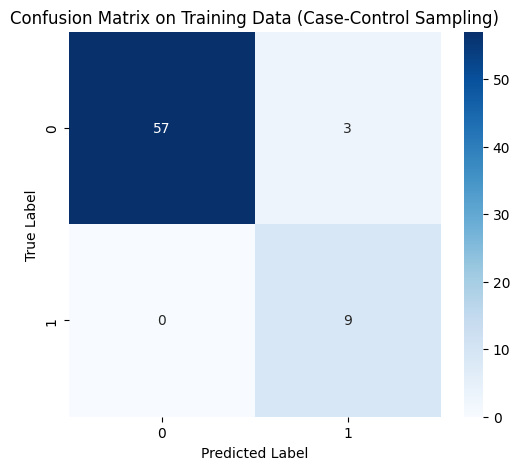

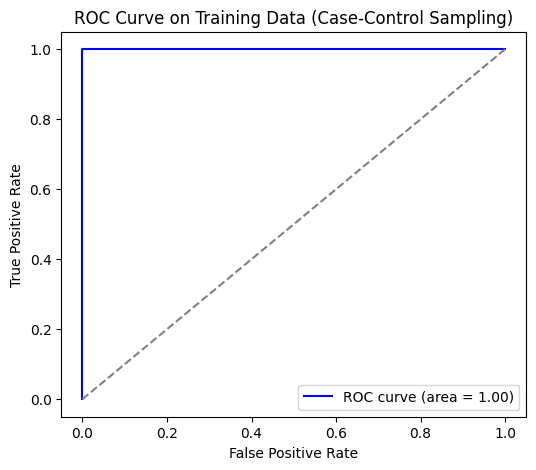

In [77]:
features_table_train["label"] = features_table["Instance"].apply(lambda x: 1 if x <= 9 else 0)
X_train = features_table_train.drop(columns=["Instance", "label"])
y_train = features_table_train["label"]

X_case = X_train[y_train == 1]
y_case = y_train[y_train == 1]

X_control, y_control = resample(X_train[y_train == 0], y_train[y_train == 0], 
                                replace=False, 
                                n_samples=len(y_case), 
                                random_state=42)

X_resampled = pd.concat([X_case, X_control])
y_resampled = pd.concat([y_case, y_control])
model = LogisticRegression(max_iter=1000)
model.fit(X_resampled, y_resampled)

y_train_pred = model.predict(X_train)
conf_matrix = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Training Data (Case-Control Sampling)")
plt.show()

y_train_prob = model.predict_proba(X_train)[:, 1]
fpr, tpr, _ = roc_curve(y_train, y_train_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Training Data (Case-Control Sampling)")
plt.legend(loc="lower right")
plt.show()


## 2.b.i

In [ ]:
def optimize_l1(features_dict, labels, l_values=range(1, 21), cv_folds=5):
    best_results = []

    for l in l_values:
        print(f"Processing l = {l} ...")
        X = features_dict[l].drop(columns=["Instance"])
        selected_cols = [col for col in X.columns if any(stat in col for stat in ["max", "min", "mean"])]
        X = X[selected_cols]
        y = labels

        model = LogisticRegressionCV(penalty="l1", solver="liblinear",  cv=cv_folds,scoring="accuracy",max_iter=1000)
        model.fit(X, y)
        best_p = np.sum(model.coef_ != 0)

        best_score = np.max(model.scores_[1].mean(axis=0))

        best_results.append((l, best_p, best_score))
        print(f"Segments: {l}, Selected Features: {best_p}, Best Score: {best_score:.4f}")

    results_df = pd.DataFrame(best_results, columns=['l', 'p', 'accuracy'])
    return results_df

Processing l = 1 ...
Segments: 1, Selected Features: 4, Best Score: 1.0000
Processing l = 2 ...
Segments: 2, Selected Features: 11, Best Score: 1.0000
Processing l = 3 ...
Segments: 3, Selected Features: 13, Best Score: 1.0000
Processing l = 4 ...
Segments: 4, Selected Features: 10, Best Score: 0.9857
Processing l = 5 ...
Segments: 5, Selected Features: 8, Best Score: 0.9571
Processing l = 6 ...
Segments: 6, Selected Features: 26, Best Score: 0.9571
Processing l = 7 ...
Segments: 7, Selected Features: 11, Best Score: 0.9714
Processing l = 8 ...
Segments: 8, Selected Features: 37, Best Score: 0.9560
Processing l = 9 ...
Segments: 9, Selected Features: 19, Best Score: 0.9714
Processing l = 10 ...
Segments: 10, Selected Features: 10, Best Score: 0.9429
Processing l = 11 ...
Segments: 11, Selected Features: 23, Best Score: 0.9703
Processing l = 12 ...
Segments: 12, Selected Features: 56, Best Score: 0.9714
Processing l = 13 ...
Segments: 13, Selected Features: 18, Best Score: 0.9714
Proces

,l,p,accuracy
0,1,4,1.000000
1,2,11,1.000000
2,3,13,1.000000
3,4,10,0.985714
4,5,8,0.957143
5,6,26,0.957143
6,7,11,0.971429
7,8,37,0.956044
8,9,19,0.971429
9,10,10,0.942857


In [ ]:
labels = features_dict[1]["Instance"].apply(lambda x: 1 if x <= 9 else 0)
results_df = optimize_l1(features_dict, labels)
results_df

## 2.b.ii

This one performs better and this is easier to implement.

## 2.c.i

I am sorry, I don't know how to solve this one. I search online about the two theorem above and find the code below.

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

model_gnb = GaussianNB()
model_mnb = MultinomialNB()

## 3: ISLR, 4.8.3

From 4.4.1, we know for k-th class:
$$
p_k(x) 
= \frac{\pi_k \,\frac{1}{\sqrt{2\pi}\,\sigma}
   \exp\!\Bigl(-\frac{(x - \mu_k)^2}{2\,\sigma^2}\Bigr)}
  {\sum_{\ell=1}^K \pi_\ell \,\frac{1}{\sqrt{2\pi}\,\sigma}
   \exp\!\Bigl(-\frac{(x - \mu_\ell)^2}{2\,\sigma^2}\Bigr)}.
$$
Without the assumption of $\hat{\sigma \text{1}}^2 = \hat{\sigma \text{2}}^2.etc$

To find the decision boundary, we compute this:
$$
\delta_k(x) = \log p_k(x) = \log \pi_k - \frac{1}{2} \log (2\pi \sigma_k^2) - \frac{(x - \mu_k)^2}{2\sigma_k^2}
$$

Open it up, we will have,  
$$
\frac{(x - \mu_k)^2}{2\sigma_k^2} = \frac{x^2 - 2\mu_k x + \mu_k^2}{2\sigma_k^2}
$$
on the right, so it is in fact quadratic


## 4: ISLR, 4.8.7

Bayes' theorem here is: 
$$
P(\text{Yes} \mid X = 4)
= \frac{P(\text{Yes}) \, f_{X \mid \text{Yes}}(4)}{P(\text{Yes}) \, f_{X \mid \text{Yes}}(4) \;+\; P(\text{No}) \, f_{X \mid \text{No}}(4)}.
$$

Apply pdf for P(Yes) and P(No):

 $$
  f_{X \mid \text{Yes}}(x)
  = \frac{1}{\sqrt{2\pi}\,\sigma} 
    \exp\!\Bigl(-\frac{(x-\mu_{\text{Yes}})^2}{2\sigma^2}\Bigr).
  $$

 $$
  f_{X \mid \text{No}}(x)
  = \frac{1}{\sqrt{2\pi}\,\sigma} 
    \exp\!\Bigl(-\frac{(x-\mu_{\text{No}})^2}{2\sigma^2}\Bigr).
  $$

We know: <br>
 P(Yes) = 0.8, P(No) = 0.2, x = 4 <br>
 $\hat{\sigma}^2 = 36$, thus $\sigma = 6$ <br>
 $\mu_{\text{Yes}}$ = 10 and $\mu_{\text{No}}$ = 0 <br>

Plug them into Bayes' theorem:
$$
P(\text{Yes} \mid X=4)
= \frac{\,0.8 \times \frac{1}{6\sqrt{2\pi}} \, e^{-\tfrac12}\,}
        {\,0.8 \times \frac{1}{6\sqrt{2\pi}} \, e^{-\tfrac12}
         + 0.2 \times \frac{1}{6\sqrt{2\pi}} \, e^{-\tfrac{2}{9}}\,}.
$$
We can cancel out $\frac{1}{6\sqrt{2\pi}}$ because both numerator and denominator have it. 

Calculate, and we have 
$$
P(\text{Yes} \mid X=4)
= \frac{0.485}{0.645} \approx 0.752.
$$


## REFERENCE

Case-control sampling
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

model_gnb = GaussianNB()
model_mnb = MultinomialNB()